In [1]:
from __future__ import division

import timeit

import threading
import random
import dubins
import time
import math
import sys
import os

from matplotlib import pyplot as plt

import seaborn

%matplotlib inline

sys.path.append(os.path.abspath('..'))

In [2]:
# Utilities
def normalize_angle(theta):
    return math.atan2(math.sin(theta), math.cos(theta))

class Pose(object):
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = normalize_angle(theta)
    
    def as_tuple(self):
        return (self.x, self.y, self.theta)


In [3]:
class RRTPlanner(object):
    def __init__(self, sample_free, steer, drivable, distance, neigbourhood_size):
        self.sample_free = sample_free
        self.distance = distance
        self.drivable = drivable
        self.steer = steer
        
        self.neigbourhood_size = neigbourhood_size
    
        self.graph  = {}
        self.parent = {}
        self.cost   = {}
        self.failed_points = {}
        self.failed_rands = {}

    def add_first_node(self, point):
        self.graph[point] = []
        self.cost[point] = 0

    def step(self):
        x_rand = self.sample_free()
        x_nearest = self.nearest_neighbour(x_rand)

        x_new = self.steer(x_nearest, x_rand)

        if self.drivable(x_nearest, x_new):
            X_near = self.neighbourhood(x_new)

            x_min = x_nearest
            c_min = self.cost[x_nearest] + self.distance(x_nearest, x_new)

            for x_near in X_near:
                if self.drivable(x_near, x_new) and (self.cost[x_near] + self.distance(x_near, x_new) < c_min):
                    x_min = x_near
                    c_min = self.cost[x_near] + self.distance(x_near, x_new)

            self.add_node(x_min, x_new)

            for x_near in X_near:
                if self.drivable(x_new, x_near) and (self.cost[x_new] + self.distance(x_new, x_near) < self.cost[x_near]):
                    self.reparent(x_near, x_new)
        else:
            self.failed_points[x_new] = x_nearest
            self.failed_rands[x_new] = x_rand

    def nearest_neighbour(self, x_rand):
        min_dist = 100000

        closest = None

        for node in self.graph:
            dist = self.distance(node, x_rand)

            if dist < min_dist:
                min_dist = dist
                closest = node

        return closest

    def neighbourhood(self, x_rand):
        neighbourhood = []

        for node in self.graph:
            if self.distance(node, x_rand) <= self.neigbourhood_size:
                neighbourhood.append(node)

        return neighbourhood

    def add_node(self, start, end):
        self.graph[end] = []
        self.graph[start].append(end)
        self.parent[end] = start
        self.cost[end] = self.cost[start] + self.distance(start, end)
    
    def reparent(self, node, new_parent):
        self.graph[self.parent[node]].remove(node)
        
        self.parent[node] = new_parent
        self.graph[new_parent].append(node)
        self.cost[node] = self.cost[new_parent] + self.distance(new_parent, node)

    def path(self, current):
        path = [current]

        if current not in self.parent:
            next_currents = self.neighbourhood(current)
            
            best_current = None
            cost_current = 10000
    
            for next_current in next_currents:
                if self.drivable(next_current, current):
                    if self.cost[next_current] + self.distance(next_current, current) < cost_current:
                        best_current = next_current
                        cost_current = self.cost[next_current] + self.distance(next_current, current)

            if best_current:
                current = best_current
                
                path.append(current)
            else:
                return None
        
        while current in self.parent:        
            current = self.parent[current]

            path.append(current)

        return path


In [4]:
def sample():
    while True:
        sample = Pose(
            random.uniform(x_max, x_min), 
            random.uniform(y_max, y_min), 
            2 * math.pi * random.random()
        )

        if drivable_point(sample):
            return sample

def steer(start, end):
    return end

    if euclidean_distance(start, end) < node_length:
        return end
    else:
        theta = math.atan2(end.x - start.x, end.y - start.y)
        x = start.x + node_length * math.cos(theta)
        y = start.y + node_length * math.sin(theta)
        return Pose(x, y, end.theta)

def drivable(start, end):
    qs, _ = dubins.path_sample(start.as_tuple(), end.as_tuple(), turning_radius, collision_step_size)

    for x, y, phi in qs:
        if not drivable_point(Pose(x, y, phi)):
            return False

    return True

def drivable_point(point):
    for obstacle in obstacles:
        x_dist = math.fabs(obstacle['center'][0] - point.x)
        y_dist = math.fabs(obstacle['center'][2] - point.y)

        x_collision = x_dist < (obstacle['extents'][0] + 1.5)
        y_collision = y_dist < (obstacle['extents'][2] + 1.5)

        if x_collision and y_collision:
            return False
    
    if point.x > x_max or point.x < x_min:
        return False
    
    if point.y > y_max or point.y < y_min:
        return False
    
    return True

def distance(p1, p2):
    return math.fabs(dubins.path_length(p1.as_tuple(), p2.as_tuple(), turning_radius))

def euclidean_distance(p1, p2):
    return math.sqrt(
        (p1.x - p2.x) ** 2 +
        (p1.y - p2.y) ** 2
    )


In [5]:
def sample():
    while True:
        sample_x = random.uniform(x_max, x_min)
        sample_y = random.uniform(y_max, y_min)
        
        theta = math.atan2(end.y - sample_y, end.x - sample_x)

        sample = Pose(sample_x, sample_y, theta + math.radians(45) * random.uniform(-1, 1))

        if drivable_point(sample):
            return sample

random.seed()

turning_radius = 3
collision_step_size = 2

node_length = 5
neigbourhood_size = 10

x_max, x_min =   4, 0
y_max, y_min =  20, 0

# Obstacles
obstacles = [
   {
       "type": "Blockers",
       "center": [0, 0, 5],
       "extents": [0.5, 0, 0.5], # Span of obstacle from center
   },
   {
       "type": "Blockers",
       "center": [3, 0, 15],
       "extents": [0.5, 0, 0.5],
   }
]

# Start and end
start = Pose(0,  0, math.radians(90))
end =   Pose(3, 20, math.radians(90))

planner = RRTPlanner(sample, steer, drivable, distance, neigbourhood_size)

planner.add_first_node(start)

t1 = timeit.default_timer()

for step in range(0, 1000):
    if step % 10 == 0 and planner.path(end):
        print "Step {}".format(step)

        break

    planner.step()

t2 = timeit.default_timer()

print "{} ms".format((t2 - t1) * 1000)

Step 100
4.74286079407 ms


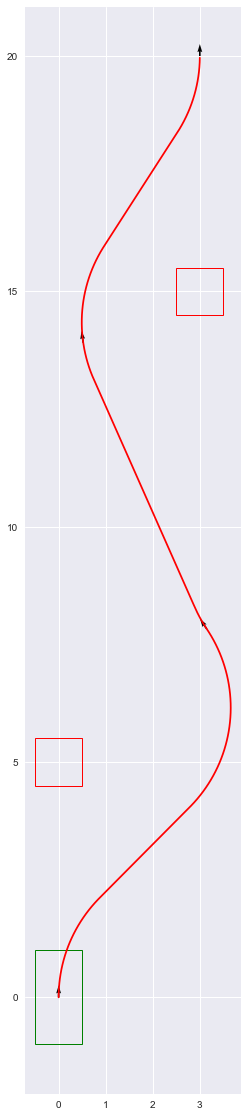

In [6]:
fig, ax = plt.subplots(1, figsize=(20, 20))

for obstacle in obstacles:
    xy = (
        obstacle['center'][0] - obstacle['extents'][0],
        obstacle['center'][2] - obstacle['extents'][2],
    )
    
    width  = obstacle['extents'][0] * 2
    height = obstacle['extents'][2] * 2

    ax.add_patch(plt.Rectangle(xy, width, height, linewidth=1,edgecolor='r',facecolor='none'))

mule_xy = (0 - 0.5, 0 - 1,)

ax.add_patch(plt.Rectangle(mule_xy, 1, 2, linewidth=1,edgecolor='g',facecolor='none'))

ax.set_aspect('equal')

xs = []
ys = []
us = []
vs = []

# Other paths

# for start, tos in planner.graph.iteritems():
#     xs.append(start.x)
#     ys.append(start.y)
#     us.append(math.cos(start.theta))
#     vs.append(math.sin(start.theta))

#     for to in tos:
#         qs, _ = dubins.path_sample(start.as_tuple(), to.as_tuple(), turning_radius, 0.1)

#         plt.plot([q[0] for q in qs], [q[1] for q in qs], color='g')

# Failed paths

# for to, start in planner.failed_points.iteritems():
#     xs.append(to.x)
#     ys.append(to.y)
#     us.append(math.cos(to.theta))
#     vs.append(math.sin(to.theta))

#     qs, _ = dubins.path_sample(start.as_tuple(), to.as_tuple(), turning_radius, 0.1)

#     plt.plot([q[0] for q in qs], [q[1] for q in qs], color='r')

path = planner.path(end)

if path:
    path.reverse()

    for to in path:
        xs.append(to.x)
        ys.append(to.y)
        us.append(math.cos(to.theta))
        vs.append(math.sin(to.theta))

    plt.quiver(xs, ys, us, vs)

    xs = []
    ys = []

    for fro, to in zip(path, path[1:]):
        qs, _ = dubins.path_sample(fro.as_tuple(), to.as_tuple(), turning_radius, 0.1)

        xs += [q[0] for q in qs]
        ys += [q[1] for q in qs]

    plt.plot(xs, ys, color='r')

plt.show()